# GAD
## Gesture activity detector

The objective of this system is to detect the window in which the user makes a gesture. This notebook contains the following parts:

- Database utils: Functions to load the database.
- Testing: To represent only one for each gesture energy graphs.
- Production: The specific script to detect and get the windows with the gestures.

## Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

## Global variables

In [7]:
ANNOTATIONS_FILE_PATH = "/mnt/RESOURCES/josemanuelbravo/GestureRecognitionSystem/data/IPN_Hand/annotations/Annot_List.txt"

INTERPOLATION = 0 #Number of frames generated between two frames
VIDEO_LENGTH = 100 * (1+INTERPOLATION) #Number of frames in the original video

# Specific production variables
WINDOW_SIZE = 10

idx_to_label = {
    1: "Non-gesture",
    2: "Pointing with one finger",
    3: "Pointing with two fingers",
    4: "Click with one finger",
    5: "Click with two fingers",
    6: "Throw up",
    7: "Throw down",
    8: "Throw left",
    9: "Throw right",
    10: "Open twice",
    11: "Double click with one finger",
    12: "Double click with two fingers",
    13: "Zoom in",
    14: "Zoom out"
}

## Database utils

In [8]:
def generate_video_landmarks(annotations_list):
    '''
        Gets the annotation list of a video and returns a tuple with the array of landmarks and the label of the video.

        Params:
         -annotations_list: List with the information of the video: [video_name, label_name, label, first_frame, last_frame, number_frames]

        Returns:
         -(landmarks, label)
    '''
    video_name = annotations_list[0]
    first_frame = (annotations_list[3] - 1) * (INTERPOLATION+1)  #Minus 1 because the first frame is 0
    last_frame = (annotations_list[4] - 1) * (INTERPOLATION+1)

    #Recover the landmarks from the csv files
    if (INTERPOLATION == 0):
        csv_path = os.path.join("../features/IPN_Hand/pose_features_w_interp/",f"{video_name}_poses_landamarks.csv")
    else:
        csv_path = os.path.join(f"../features/IPN_Hand/pose_features_w_interp_interp_{INTERPOLATION}/",f"{video_name}_poses_landamarks.csv")
    full_video_landmarks = pd.read_csv(csv_path).to_numpy()

    #Load all landmarks of the video
    landmarks = full_video_landmarks[first_frame:last_frame+1,0:42]
    #Add 10 frames of 0's to separate the video from the repetition
    #landmarks = np.pad(landmarks, ((0,10),(0,0)), "constant", constant_values=0)

    #Cut or padding the video so all have the same lenght
    if (landmarks.shape[0] > VIDEO_LENGTH):
        landmarks = landmarks[0:VIDEO_LENGTH,:]
    else:
        landmarks = np.pad(landmarks, ((0,VIDEO_LENGTH-landmarks.shape[0]),(0,0)), "constant", constant_values=0)

    landmarks = landmarks.astype(np.float32)

    return landmarks

## Testing
 

[array(['1CM42_26_R_#175', 'B0A', 2, 2955, 3199, 245], dtype=object), array(['1CM42_26_R_#175', 'B0B', 3, 1440, 1666, 227], dtype=object), array(['1CM1_2_R_#224', 'G01', 4, 35, 87, 53], dtype=object), array(['1CM1_2_R_#224', 'G02', 5, 3340, 3368, 29], dtype=object), array(['1CM1_2_R_#224', 'G03', 6, 2917, 2979, 63], dtype=object), array(['1CM1_2_R_#223', 'G04', 7, 3369, 3421, 53], dtype=object), array(['1CM1_2_R_#224', 'G05', 8, 2400, 2446, 47], dtype=object), array(['1CM1_2_R_#224', 'G06', 9, 873, 930, 58], dtype=object), array(['1CM1_2_R_#224', 'G07', 10, 2106, 2162, 57], dtype=object), array(['1CM1_2_R_#224', 'G08', 11, 3651, 3693, 43], dtype=object), array(['1CM1_2_R_#224', 'G09', 12, 566, 600, 35], dtype=object), array(['1CM1_2_R_#224', 'G10', 13, 1340, 1389, 50], dtype=object), array(['1CM1_2_R_#224', 'G11', 14, 274, 343, 70], dtype=object)]


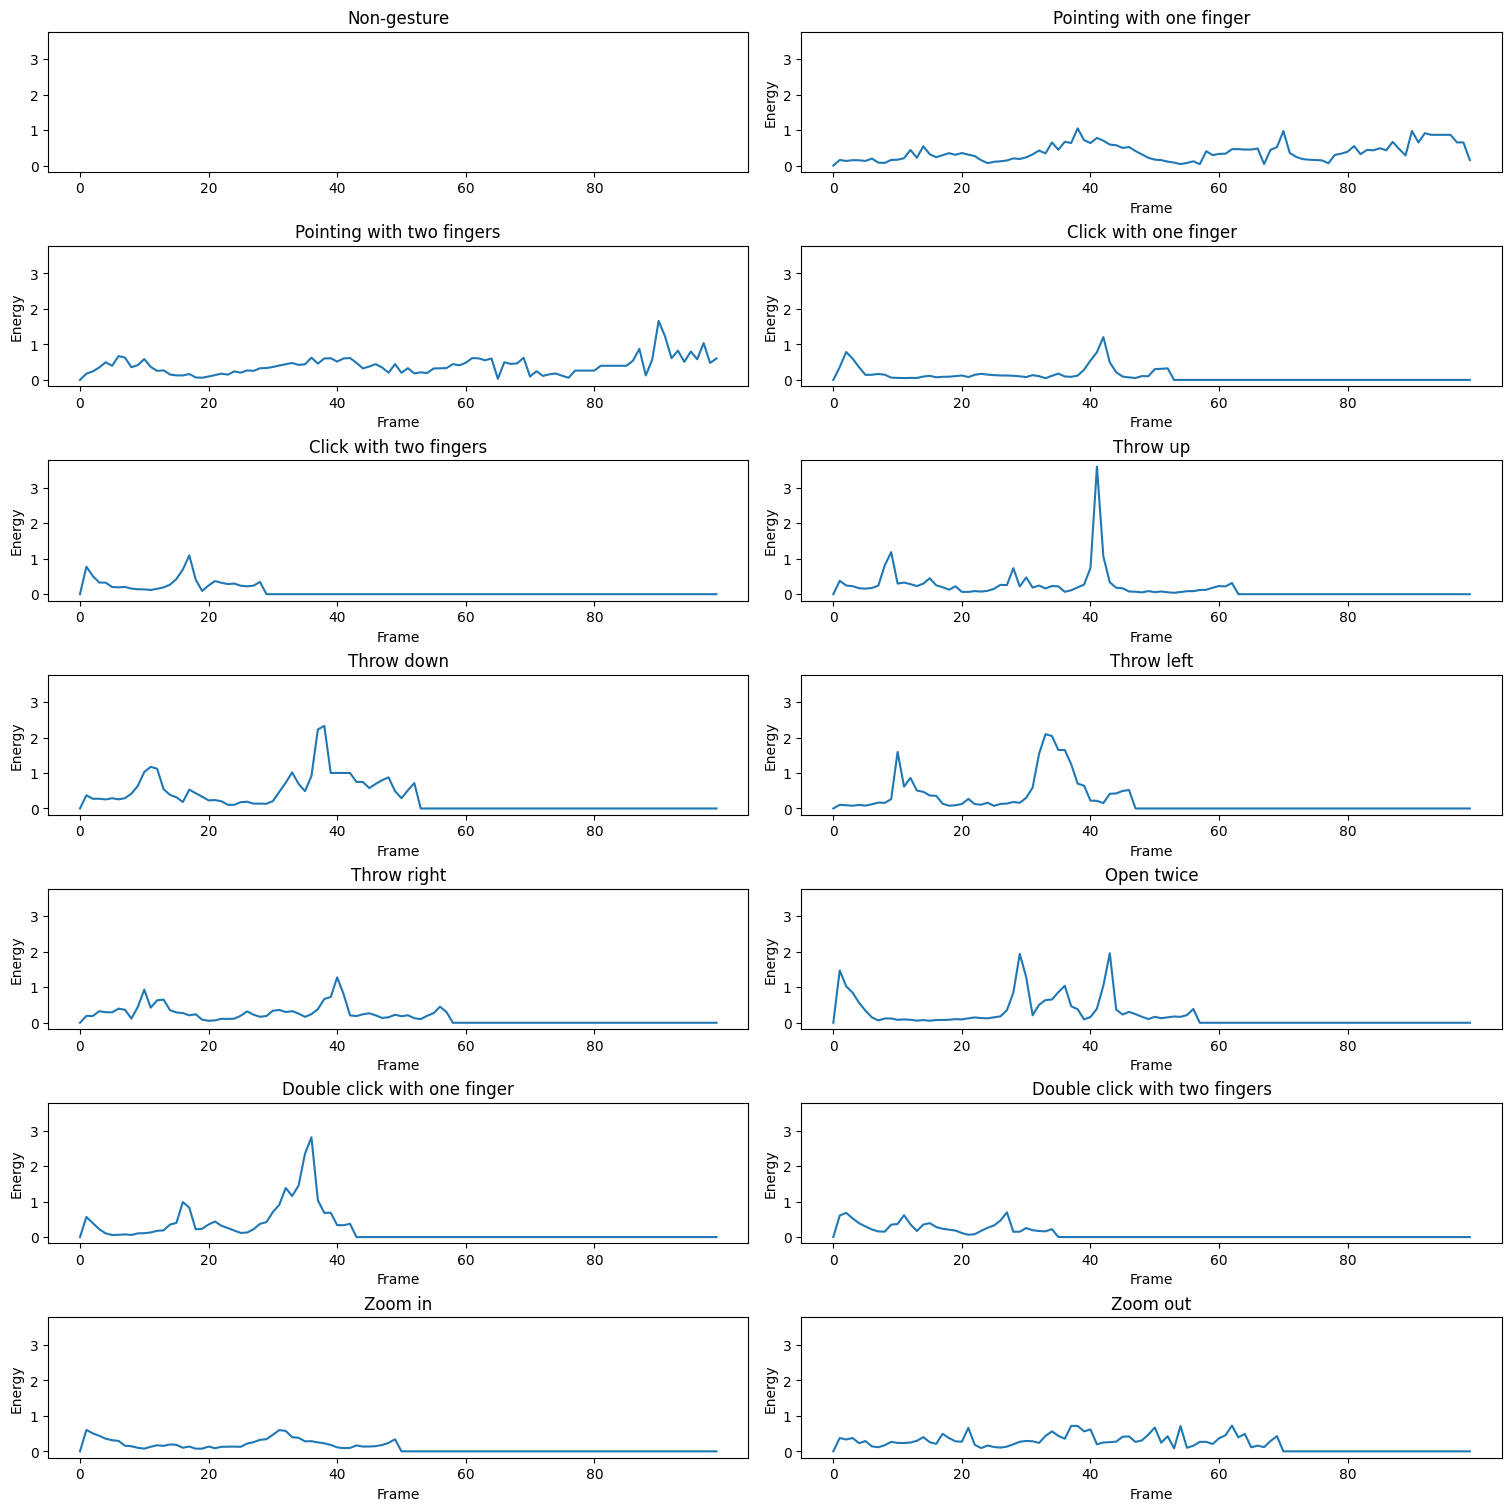

In [9]:
#Prepare the figure graph
fig, axs = plt.subplots(7,2,figsize=(15,15), constrained_layout = True)
axs = axs.flatten()
axs[0].set_title("Non-gesture")
# Read annotations file
annotations = pd.read_csv(ANNOTATIONS_FILE_PATH)
# Generate a list of gestures samples
list_gestures = []
for gesture in range(2,15):
    list_gestures.append(annotations[annotations["label"] == gesture].to_numpy()[155])

#Generate and plot the energy of each gesture
##############################################################################################################
for label in range(13):
    gesture = list_gestures[label]
    landmarks = generate_video_landmarks(gesture)

    energy_list = []
    for i in range(VIDEO_LENGTH):
        energy = 0
        if i == 0:
            energy_list.append(0)
            continue

        frame = landmarks[i,:]
        prev_frame = landmarks[i-1,:]

        if (frame.sum() == 0 or prev_frame.sum() == 0):
            energy_list.append(0)
            continue

        for j in range(0,42,2):
            energy += np.sqrt((frame[j] - prev_frame[j])**2 + (frame[j+1] - prev_frame[j+1])**2)

        energy_list.append(energy)

    #plot the energy
    ax = axs[label+1]
    ax.sharex(axs[1])
    ax.sharey(axs[1])
    ax.set_xlabel("Frame")
    ax.set_ylabel("Energy")
    ax.set_xticks(np.arange(0,VIDEO_LENGTH,20))
    ax.set_title(f"{idx_to_label[label+2]}")
    ax.plot(energy_list)
##############################################################################################################
#Print the videos information

axs[0].sharex(axs[1])
axs[0].sharey(axs[1])
print(list_gestures)

## Production

In [6]:
def get_energy_between_frames(frame, prev_frame):
    '''
        Gets the energy between two frames of a video. If one of the frames is 0, the energy is 0.

        Params:
         -frame: Array with the landmarks of the frame
         -prev_frame: Array with the landmarks of the previous frame

        Returns:
         -energy: The energy between the two frames
    '''
    energy = 0
    if (frame.sum() == 0 or prev_frame.sum() == 0):
        return 0

    for j in range(0,42,2):
        energy += np.sqrt((frame[j] - prev_frame[j])**2 + (frame[j+1] - prev_frame[j+1])**2)

    return energy

def get_gesture_energy(landmarks: np.ndarray):
    '''
        Gets the energy of a video.

        Params:
         -landmarks: Array with the landmarks of the video

        Returns:
         -gesture_energy: The energy of the video
    '''
    gesture_energy = np.empty(landmarks.shape[0] - 1, dtype=np.float32)

    for i in range (0, landmarks.shape[0] - 1):
        energy = get_energy_between_frames(landmarks[i,:], landmarks[i+1,:])
        gesture_energy[i] = energy

    return gesture_energy

def get_gesture_window_with_more_energy(landmarks: np.ndarray , window_size = WINDOW_SIZE, step = 1):
    '''
        Gets the gesture window of a video. The gesture window is the window with the highest energy of the video.

        Params:
         -landmarks: Array with the landmarks of the video
         -window_size: Size of the window to calculate the energy
         -step: Step to move the window. Default is 1

        Returns:
         -gesture_window: The gesture window of the video
    '''
    gesture_window = landmarks[0:window_size,:]
    
    gesture_energy = get_gesture_energy(landmarks)

    energy = np.array(gesture_energy[0:window_size]).sum()
    max_energy = energy
    first_frame = 0

    for i in range(1, len(gesture_energy)-(window_size-1), step):
        energy = energy - gesture_energy[i-step:i].sum() + gesture_energy[i+(window_size-step):i+window_size].sum()
        if energy > max_energy:
            max_energy = energy
            gesture_window = landmarks[i:i+window_size,:]
            first_frame = i

    print(f"First frame: {first_frame}")

    return gesture_window

def get_gesture_window_from_energy_threshold(landmarks, window_size = 51, energy_threshold = 0.5):
    '''
        Gets the gesture window of a video. The gesture window is the window with length window_size centered in the first frame with energy higher than energy_threshold.

        Params:
         -landmarks: Array with the landmarks of the video
         -window_size: Size of the window to calculate the energy. It must be an odd number
         -energy_threshold: Threshold to consider a frame as a peak. Default is 0.5

        Returns:
            -gesture_window: The gesture window of the video
    '''
    if window_size % 2 == 0:
        raise ValueError("window_size must be an odd number")

    gesture_window = landmarks[0:window_size,:]
    
    gesture_energy = get_gesture_energy(landmarks)

    for i in range(int(window_size/2), len(gesture_energy)-(int(window_size/2)-1)):
        if gesture_energy[i] > energy_threshold:
            gesture_window = landmarks[i-int(window_size/2):i+int(window_size/2)+1,:]
            break

    return gesture_window
    
def get_gesture_window_from_peak(landmarks, window_size = 51):
    '''
        Gets the gesture window of a video. The gesture window is the window with length window_size centered in the absolute peak of the video.

        Params:
         -landmarks: Array with the landmarks of the video
         -window_size: Size of the window to calculate the energy. It must be an odd number

        Returns:
            -gesture_window: The gesture window of the video. Default is 51.
    '''
    if window_size % 2 == 0:
        raise ValueError("window_size must be an odd number")

    gesture_window = landmarks[0:window_size,:]
    
    gesture_energy = get_gesture_energy(landmarks)
    max_energy = gesture_energy[0]

    for i in range(int(window_size/2), len(gesture_energy)-(int(window_size/2)-1)):
        energy = gesture_energy[i]
        if energy > max_energy:
            max_energy = energy
            gesture_window = landmarks[i-int(window_size/2):i+int(window_size/2)+1,:]

    return gesture_window

### Test for production

First frame: 344
First frame: 332
First frame: 128
First frame: 0
First frame: 100
First frame: 124
First frame: 104
First frame: 100
First frame: 104
First frame: 76
First frame: 0
First frame: 76
First frame: 128
[array(['1CM42_26_R_#175', 'B0A', 2, 2955, 3199, 245], dtype=object), array(['1CM42_26_R_#175', 'B0B', 3, 1440, 1666, 227], dtype=object), array(['1CM1_2_R_#224', 'G01', 4, 35, 87, 53], dtype=object), array(['1CM1_2_R_#224', 'G02', 5, 3340, 3368, 29], dtype=object), array(['1CM1_2_R_#224', 'G03', 6, 2917, 2979, 63], dtype=object), array(['1CM1_2_R_#223', 'G04', 7, 3369, 3421, 53], dtype=object), array(['1CM1_2_R_#224', 'G05', 8, 2400, 2446, 47], dtype=object), array(['1CM1_2_R_#224', 'G06', 9, 873, 930, 58], dtype=object), array(['1CM1_2_R_#224', 'G07', 10, 2106, 2162, 57], dtype=object), array(['1CM1_2_R_#224', 'G08', 11, 3651, 3693, 43], dtype=object), array(['1CM1_2_R_#224', 'G09', 12, 566, 600, 35], dtype=object), array(['1CM1_2_R_#224', 'G10', 13, 1340, 1389, 50], dtype

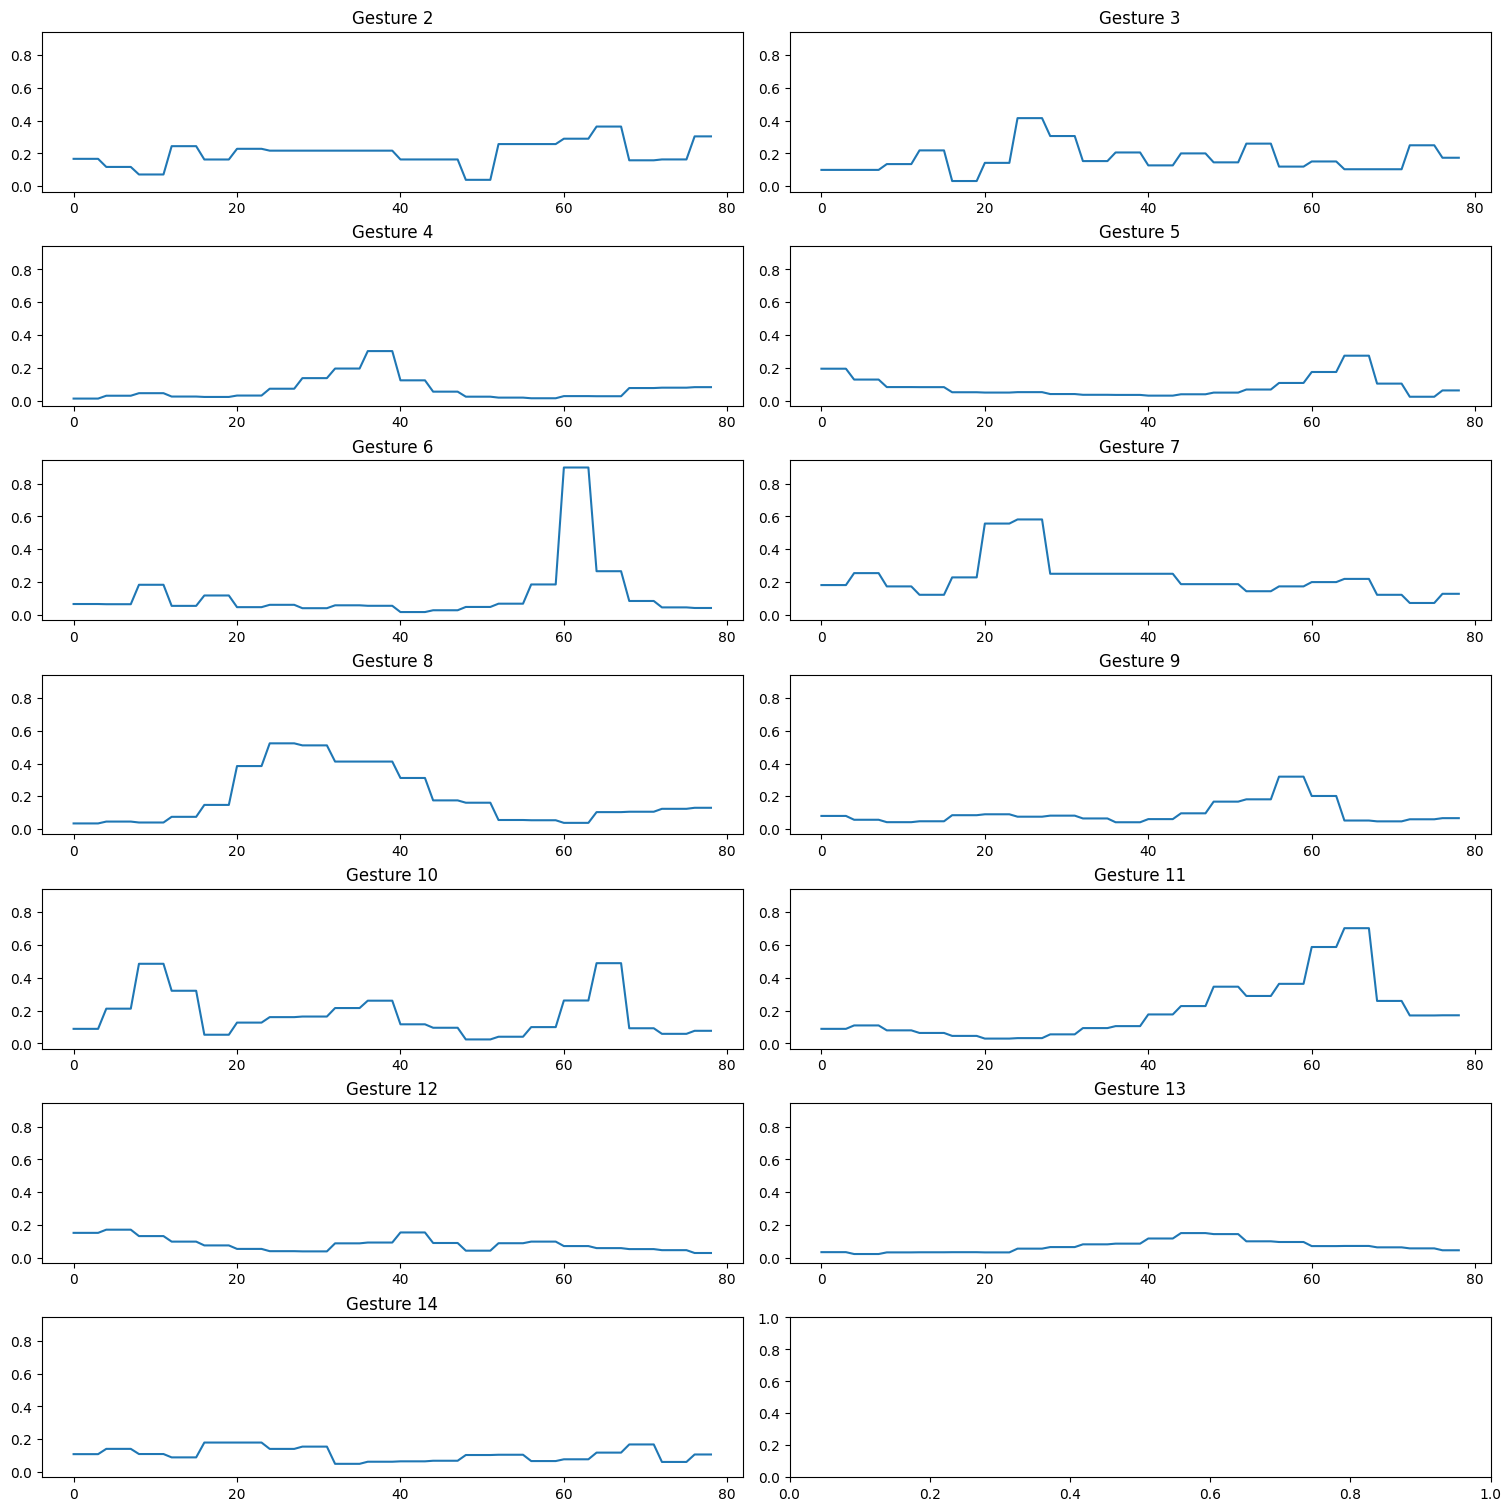

In [8]:
#Prepare the figure graph
fig, axs = plt.subplots(7,2,figsize=(15,15), constrained_layout = True)
axs = axs.flatten()
# Read annotations file
annotations = pd.read_csv(ANNOTATIONS_FILE_PATH)
# Generate a list of gestures samples
list_gestures = []
for gesture in range(2,15):
    list_gestures.append(annotations[annotations["label"] == gesture].to_numpy()[155])


for label in range(13):
    gesture = list_gestures[label]
    landmarks = generate_video_landmarks(gesture)

    landmarks = get_gesture_window_with_more_energy(landmarks, window_size=80)

    landmarks_energy = get_gesture_energy(landmarks)

    #plot the energy
    ax = axs[label]
    ax.sharex(axs[0])
    ax.sharey(axs[0])
    ax.set_xticks(np.arange(0,VIDEO_LENGTH,20))
    ax.set_title(f"Gesture {label+2}")
    ax.plot(landmarks_energy)
##############################################################################################################
#Print the videos information
print(list_gestures)